# Trabajo practico integrado Comunicaciones digitales

Este trabajo práctico tiene como objetivo estudiar el funcionamiento del sistema de comunicación LoRaWAN. LoRaWAN es una red de tipo LPWAN (Low Power Wide Area Network), la cual utiliza LoRa (Long Range) como su tecnología de modulación.

Una LPWAN es una red de telecomunicaciones diseñada específicamente para la comunicación de dispositivos que requieren cobertura de largo alcance y bajo consumo energético, características fundamentales en aplicaciones de Internet de las Cosas (IoT).

Con el fin de analizar en profundidad este sistema, se propone la lectura y el estudio de dos artículos científicos:

1. "Frequency Shift Chirp Modulation: The LoRa Modulation" – Lorenzo Vangelista

2. "From Demodulation to Decoding: Toward Complete LoRa PHY Understanding and Implementation" – Zhenqiang Xu, Shuai Tong, Pengjin Xie y Jiliang Wang

A partir del análisis de estos trabajos, se derivan los siguientes resultados y conclusiones sobre el sistema de modulación y funcionamiento de la capa física (PHY) en LoRaWAN.


## Codificador y Decodificador

### Codificador
La codificación propuesta se realiza mediante el polinomio de numeración posicional en base 2. Para ello, se requiere la elección de un parámetro conocido como _Spreading Factor_ ($SF$), el cual puede tomar los siguientes valores: $\{7,8,9,10,11,12\}$. Este parámetro representa la cantidad de dígitos binarios que conforman un símbolo.

Para generar un símbolo, se utiliza la siguiente ecuación:

$$\Large s(nT_s) = \sum_{h=0}^{\text{SF}-1} \text{w}(nT_s)_h \cdot 2^h$$

Donde $T_s$ es el período de un símbolo, y $n$ es el índice del símbolo que indica la posición temporal dentro de la secuencia.

Por ejemplo, si se tiene un $SF=8$ y se desea codificar el dato 0 1 1 1 1 0 0 0:

$$s(nT_s) = \sum_{h=0}^{7} \text{w}(nT_s)_h \cdot 2^h = 0*2^7 + 1*2^6 + 1*2^5 + 1*2^4 + 1*2^3 + 0*2^2 + 0*2^1 + 0*2^0 = 120$$





In [187]:
import numpy as np
import matplotlib.pyplot as plt

In [188]:
    # Generador de bits aleatorios
def generate_random_bits(total_bits):
    return np.random.randint(0, 2, total_bits)


In [189]:
def codificador(bits_tx, SF=8):
    """Codifica un señal binaria mediante el polinomio de numeración posicional en base 2 

    Args:
        bits_tx (list): Arreglo unidimensional de bits (0s y 1s) que representa la señal binaria a codificar.
        SF (int, optional): Spreading factor valor entero que representa la cantidad de bits que componen un simbolo puede tomar valores [7,12]. Defaults to 8.

    Returns:
        (list) simbolos_tx: Simbolos codificados en base 2.
    """
    if(SF < 7 or SF > 12):
        raise ValueError("El Spreading Factor debe ser un valor entero entre 7 y 12")
    
    bits_estructurados = bits_tx.reshape(-1, SF) #Toma el arreglo de bits y lo reestructura en una matriz de tamaño num_simbolos x SF         
    potencias = 2**np.arange(SF) #Arreglo de potencias de 2 para realizar la codificación de los símbolos
    simbolos_tx = np.dot(bits_estructurados, potencias) # Producto interno entre los bits estructurados y las potencias de 2 para obtener los símbolos codificados         

    return simbolos_tx


### Decodificador

El decodificador implementa el algoritmo de divisiones sucesivas por 2 para recuperar el dato a partir del símbolo recibido. El procedimiento consiste en dividir el número original entre 2 de forma repetida. En cada división, se registra el residuo o módulo (que siempre será 0 o 1), y se reemplaza el número por el cociente entero obtenido. Este proceso se repite hasta que el cociente sea igual a cero. Finalmente, el número binario se construye leyendo los residuos en orden inverso al que fueron generados; es decir, desde el último hasta el primero.

$$\large \mathbf{w}(nT_s)_h = \left( \left\lfloor \frac{s(nT_s)}{2^h} \right\rfloor \bmod 2 \right), \quad h = 0, 1, \dots, SF - 1$$

$$\mathbf{w}(nT_s) = \left[
\left\lfloor \frac{s(nT_s)}{2^0} \right\rfloor \bmod 2,\ 
\left\lfloor \frac{s(nT_s)}{2^1} \right\rfloor \bmod 2,\ 
\ldots,\ 
\left\lfloor \frac{s(nT_s)}{2^{SF - 1}} \right\rfloor \bmod 2
\right]$$

In [190]:
def decodificador(simbolos_rx, SF=8):
    """Decodifica una señal binaria mediante el polinomio de numeración posicional en base 2 
    
    Args:
        SF (int, optional): Spreading factor valor entero que representa la cantidad de bits que componen un simbolo codificado puede tomar valores [7,12]. Defaults to 8.
        simbolos_rx (_type_, optional): _description_. Defaults to None.
        
    Returns:
        (list) simbolos_tx: Simbolos decodificados en base 2.
    """
    if(SF < 7 or SF > 12):
        raise ValueError("El Spreading Factor debe ser un valor entero entre 7 y 12")
    
    bits_rx = []

    for simbolo in simbolos_rx:
        bits = []
        for _ in range(SF):
            # Algoritmo de division sucesiva por 2 para obtener los bits del simbolo
            bits.append(simbolo % 2)
            simbolo = simbolo//2
        bits_rx.extend(bits)

    return np.array(bits_rx)

### Bit error rate

El _Bit Error Rate_ (BER) representa la proporción de bits recibidos con error respecto al total de bits transmitidos. Se calcula de la siguiente forma:

$$BER=\frac{\text{número de bits erróneos}}{\text{total de bits transmitidos}}$$

In [191]:
def calculador_ber(bits_tx, bits_rx):
    """Calcula la tasa de error de bit (BER) entre los bits transmitidos y recibidos.

    Args:
        bits_tx (list): Arreglo unidimensional de bits transmitidos.
        bits_rx (list): Arreglo unidimensional de bits recibidos.

    Returns:
        float: Tasa de error de bit (BER).
    """
    if len(bits_tx) != len(bits_rx):
        raise ValueError("Los arreglos de bits transmitidos y recibidos deben tener la misma longitud.")
    
    errores = np.sum(bits_tx != bits_rx)
    ber = errores / len(bits_tx)
    
    return ber

In [192]:
# Ejemplo de uso

#Configuración/Parametros
SF = 8
cant_simbolos = 10
total_bits = SF * cant_simbolos

B=125e3

# Generación de bits aleatorios
bits_tx = generate_random_bits(total_bits)

# Codificacion
simbolos_tx = codificador(bits_tx, SF)

print("Bits transmitidos:\n(LSB) (MSB)")
for i in range(0, len(bits_tx), SF):
    print(*bits_tx[i:i+SF])
    
print("Símbolos codificados:", simbolos_tx)
# Decodificacion
bits_rx = decodificador(simbolos_tx, SF)

print("Bits recibidos:\n(LSB) (MSB)")
for i in range(0, len(bits_tx), SF):
    print(*bits_rx[i:i+SF])
    
print("La tasa de error de bit (BER) es: ", calculador_ber(bits_tx, bits_rx)*100, "%")

Bits transmitidos:
(LSB) (MSB)
1 0 1 1 0 1 0 0
0 1 1 0 0 1 1 0
0 0 0 0 1 1 0 1
1 1 0 0 1 1 1 0
1 1 1 0 0 0 0 1
0 1 0 0 1 0 0 0
0 0 1 1 1 0 1 0
0 1 0 0 1 0 1 1
0 0 0 1 0 0 0 1
1 0 0 1 0 1 1 0
Símbolos codificados: [ 45 102 176 115 135  18  92 210 136 105]
Bits recibidos:
(LSB) (MSB)
1 0 1 1 0 1 0 0
0 1 1 0 0 1 1 0
0 0 0 0 1 1 0 1
1 1 0 0 1 1 1 0
1 1 1 0 0 0 0 1
0 1 0 0 1 0 0 0
0 0 1 1 1 0 1 0
0 1 0 0 1 0 1 1
0 0 0 1 0 0 0 1
1 0 0 1 0 1 1 0
La tasa de error de bit (BER) es:  0.0 %


## Conformador de onda y conformador de n-tuplas

### Conformador de onda

El conformador de onda implementa la modulación _Frequency Shift Chirp Modulation_ (FSCM). En esta modulación, cada símbolo se asocia a una frecuencia inicial determinada por su valor decimal $s(nT_s)$  A partir de esta frecuencia, la señal modulada presenta un barrido lineal en frecuencia (tipo chirp), donde la frecuencia incrementa linealmente con el tiempo, siguiendo el índice $k=0,1,...,2^{SF}-1$, hasta alcanzar un valor máximo de $2^{SF}$. Luego, la frecuencia decae hasta 0 y vuelve a incrementarse, completando así una oscilación en frecuencia que regresa al valor inicial. Esta modulación al realizarse con una señal compleja, se compone de una componente en fase (I) y otra componente en cuadratura (Q).


$$\Large c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi[(s(nT_s)+k)\cdot{\bmod{2^{SF}}}](kT\frac{B}{2^{SF}})}\quad k=0,...,2^{SF}-1$$

Aplicando la ecuación de Euler se llega a la siguiente expresión equivalente:

$$c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot \left[ \cos\left(2\pi \cdot \left((s(nT_s) + k) \bmod 2^{SF}\right) \cdot k\frac{T B}{2^{SF}}\right) + j \cdot \sin\left(2\pi \cdot \left((s(nT_s) + k) \bmod 2^{SF}\right) \cdot k\frac{T B}{2^{SF}}\right) \right] \quad k = 0, \dots, 2^{SF} - 1$$

De este modo, se muestran claramente las dos partes ortogonales de la señal: la componente en fase, asociada al coseno (parte real), y la componente en cuadratura, asociada al seno (parte imaginaria)

Analizando las ecuación se pueden observar:


- $k$ Es el indice de tiempo discreto que actua como contador haciendo que la frecuencia aumente linealmente.
- La frecuencia inicial (cuando $k=0$) viene dado por el valor del simbolo $s(nT_s)$
- El modulo de $(s(nT_s) + k)$ en base $2^{SF}$ ($(s(nT_s) + k) \bmod 2^{SF}$) tiene por fin limitar el crecimiento lineal de la frecuencia hasta un valor de frecuencia maximo $2^{SF}-1$ con el proposito de limitar el ancho de banda. Esta operacion genera un discontinuidad en la frecuencia haciendo que la misma caiga desde el valor maximo hasta $0$ para luego continuar creciendo hasta el valor inicial $s(nT_s)$ finalizando el periodo $T_s$ del simbolo.
- El factor $\frac{1}{\sqrt{2^{SF}}}$ tiene por fin normalizar la potencia de la señal
- El periodo de muestreo $\frac{TB}{2^{SF}}$

In [193]:
def conformador_de_onda(simbolos, SF, B=125e3):
    """
    Genera la forma de onda LoRa para una secuencia de símbolos.

    Parámetros:
    - simbolos: matriz unidimensional de enteros entre 0 y 2**SF - 1
    - SF: Spreading Factor
    - B: Ancho de banda (Hz), por defecto 125 kHz

    Retorna:
    - matriz de forma (len(simbolos), 2**SF) con los chirps generados
    """
    Ns = 2**SF # Muestras por simbolo
    T = 1/B  # Periodo de muestreo
    k = np.arange(Ns) # Arreglo de indices de muestras
    
    simbolos_modulados = []

    for s in simbolos:
        
        arg = ((s + k) % Ns) * (k * T * B / Ns) # Obtiene el argumento de la exponencial compleja
        chirp = (1 / np.sqrt(Ns)) * np.exp(1j * 2 * np.pi * arg) # Modula el simbolo
        simbolos_modulados.append(chirp) # Agrega el simbolo modulado a la matriz

    return np.array(simbolos_modulados)  # Matriz de salida (símbolos x muestras)


### Formador de ntuplas

Para recuperar el simbolo modulado se proyecta la señal recibida $r(nT_s + kT)$ en el conjunto de bases conjugadas con las que se moduló la señal, en nuestro caso la base con la que se modulo la señal esta formada por una unica señal $c(nT_s + kT)$. Por lo tanto la proyección:

$$\langle r(nT_s+kT),c(nT_s+kT)|_{s(nT_s)=q} \rangle$$

$$=\sum_{k=0}^{2^{SF}-1}r(nT_s+kT)\, \cdot \, c^*(nT_s+kT)|_{s(nT_s)=q}$$

Se llega a la siguiente expresión:

$$=\sum_{k=0}^{2^{SF}-1}\underbrace{r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}}_{d(nT_s + kT)}\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

Reescribiendo el producto:
$$d(nT_s + kT)=r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}$$

Se tiene:

$$\sum_{k=0}^{2^{SF}-1}d(nT_s + kT)\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

La cual es la transformada de Fourier discreta de la señal $d(nT_s + kT)$


In [194]:
def formador_de_ntuplas(simbolos_modulados, SF):
    """
    Demodula la señal previamente modulada con la funcion conformador_de_onda recuperando los símbolos.

    Parámetros:
    - simbolos_modulados: matriz de (cantidad de simbolos x 2**SF) de chirps modulados
    - SF: Spreading Factor

    Retorna:
    - Lista de símbolos estimados (enteros entre 0 y 2**SF - 1)
    """
    Ns = 2**SF
    k = np.arange(Ns)
    
    
    simbolos_estimados = []
    func_aux = np.exp(-1j * 2 * np.pi * k**2 / Ns)

    for r in simbolos_modulados:
        # Multiplicación para obtener d(nTs+kT)
        d = r * func_aux
        # Calcula la transformada de Fourier discreta de d(nTs+kT)
        fft_out = np.fft.fft(d)
        # Estima el simbolo a partir del pico en frecu  encia
        simbolo_estimado = int(np.argmax(np.abs(fft_out)))

        simbolos_estimados.append(simbolo_estimado)

    return simbolos_estimados

### Symbol error rate

El _Symbol Error Rate_ (SER), similar al BER, representa la proporción de simbolos recibidos con error respecto al total de simbolos transmitidos. Se calcula de la siguiente forma:

$$SER=\frac{\text{número de simbolos erróneos}}{\text{total de simbolos transmitidos}}$$

In [195]:
def calculador_ser(simbolos_tx, simbolos_rx):
    """Calcula la tasa de error de simbolos (SER) entre los simbolos transmitidos y recibidos.

    Args:
        simbolos_tx (list): Arreglo unidimensional de simbolos transmitidos.
        simbolos_rx (list): Arreglo unidimensional de simbolos recibidos.

    Returns:
        float: Tasa de error de simbolos (SER).
    """
    if len(simbolos_tx) != len(simbolos_rx):
        raise ValueError("Los arreglos de simbolos transmitidos y recibidos deben tener la misma longitud.")
    
    errores = np.sum(simbolos_tx != simbolos_rx)
    ser = errores / len(simbolos_tx)
    
    return ser

In [196]:
def graficar_señal_modulada(simbolos_modulados, indice, SF, B=125e3):
    """
    Grafica la señal modulada en tiempo (I y Q) de un símbolo dado por su índice
    dentro de la matriz de simbolos modulados.

    Parámetros:
    - simbolos_modulados: matriz de salida de conformador_de_onda
    - indice: posición del símbolo que se desea graficar
    - SF: Spreading Factor
    - B: ancho de banda (Hz)
    """
    Ns = 2**SF # Muestras por simbolo
    T = 1/B  # Periodo de muestreo
    k = np.arange(Ns) # Arreglo de indices de muestras
    tiempo = k * T * 1e6  # microsegundos

    muestra_simbolo_mod = simbolos_modulados[indice]
    I = np.real(muestra_simbolo_mod)
    Q = np.imag(muestra_simbolo_mod)

    plt.figure(figsize=(10, 2))
    plt.plot(tiempo, I, color='blue')
    plt.title(f"Chirp LoRa - Fase (I) - índice {indice} (SF={SF})")
    plt.xlabel("Tiempo [μs]")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 2))
    plt.plot(tiempo, Q, color='red')
    plt.title(f"Chirp LoRa - Cuadratura (Q) - índice {indice} (SF={SF})")
    plt.xlabel("Tiempo [μs]")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.tight_layout()
    plt.show()

In [197]:
def graficar_todas_las_senales_moduladas(simbolos_modulados, SF, B=125e3, max_muestras=None):
    """
    Grafica la señal modulada completa solo de la parte en fase (I) concatenando los símbolos,
    y colorea cada símbolo con un color distinto.
    
    Parámetros:
    - simbolos_modulados: matriz de salida de conformador_de_onda
    - SF: Spreading Factor
    - B: Ancho de banda (Hz)
    - max_muestras: cantidad de simbolos a graficar (opcional)
    """
    Ns = 2**SF  # Muestras por símbolo
    T = 1/B     # Periodo de muestreo

    total_simbolos = max_muestras
    
    if max_muestras is None:
        total_simbolos = len(simbolos_modulados) # Si no se especifica cantidad de muestras se usan todos los simbolos.

    cmap = plt.get_cmap('tab10')  

    # Crear figura para I
    plt.figure(figsize=(18, 3)) 
    for i in range(total_simbolos):
        simbolo = simbolos_modulados[i]
        I = np.real(simbolo)
        tiempo_local = np.arange(i * Ns, (i + 1) * Ns) * T * 1e6  # tiempo en μs
        plt.plot(tiempo_local, I, label=f'Símbolo {i}', color=cmap(i % 20))

    plt.title(f'Fase (I) de todos los símbolos concatenados (SF={SF})')
    plt.xlabel('Tiempo [μs]')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


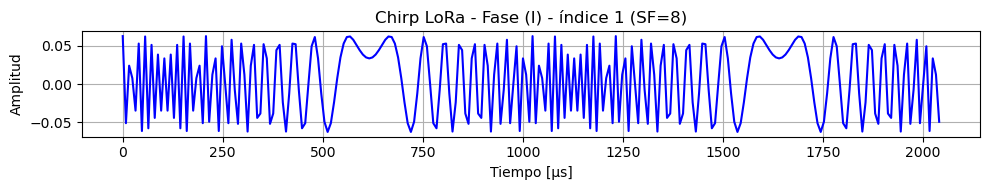

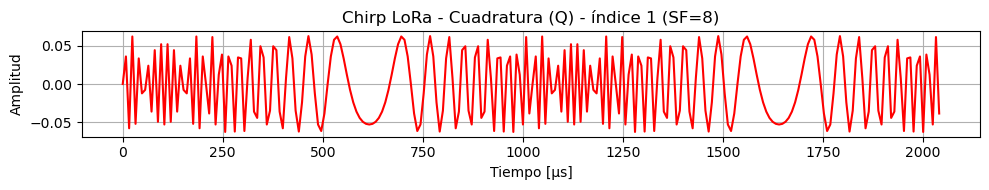

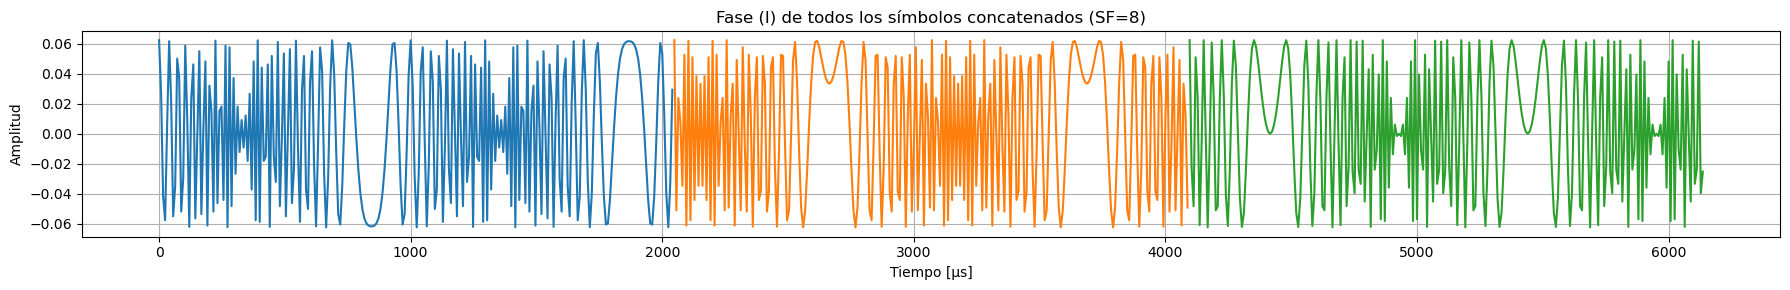

Símbolos codificados: [ 45 102 176 115 135  18  92 210 136 105]
Símbolos recibidos: [45, 102, 176, 115, 135, 18, 92, 210, 136, 105]
La tasa de error de simbolos (SER) es:  0.0 %


In [198]:
#Ejemplo de uso, continuando el ejemplo del capitulo anterior (Codificador y Decodificador)

simbolos_modulados = conformador_de_onda(simbolos_tx,SF,B)
graficar_señal_modulada(simbolos_modulados,1,SF,B)
graficar_todas_las_senales_moduladas(simbolos_modulados,SF,B,3)
simbolos_rx = formador_de_ntuplas(simbolos_modulados, SF)

print("Símbolos codificados:", simbolos_tx)
print("Símbolos recibidos:", simbolos_rx)

print("La tasa de error de simbolos (SER) es: ", calculador_ser(simbolos_tx, simbolos_rx)*100, "%")


